# Multi-step forecasting: recursive approach

In the previous notebooks, we predicted the hourly pollutant concentration for the next 24 hours utilizing a direct approach.

Here, we will carry out multi-step forecasting using a recursive approach.

## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from feature_engine.creation import (
    CyclicalFeatures,
    MathFeatures,
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Load data

In [2]:
# We carry out all data preparation steps from the
# notebook in section 2 within a function.


def load_data():

    # Data lives here.
    filename = "../datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]

    return data

In [3]:
# Load data.

data = load_data()

data.head()

,CO_sensor
Date_Time,
2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,1028.0


# Our feature engineering class

In [4]:
class SeasonalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, season_var, variables):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate the seasonal variable
        # and the variables that should be aggregated.

        self.season_var = season_var
        self.variables = variables

    def fit(self, X, y=None):

        # We want to estimate the mean value of the
        # time series in the seasonal term.

        # In our demo, that is the mean pollutant's
        # concentration per hour.

        # We make a copy of the dataframe
        # not to over-write the user's data.
        X = X.copy()

        # Calculate mean pollutant per hr.
        # The learned values will be stored in this attribute.
        self.seasonal_ = X.groupby(self.season_var)[self.variables].mean()

        # Rename the new variables.
        self.seasonal_.columns = [v + "_season" for v in self.variables]

        # Reset index
        self.seasonal_ = self.seasonal_.reset_index()

        return self

    def transform(self, X):

        # Add the seasonal component to the
        # dataset to transform.

        X = X.copy()

        # Store the datetime index (it is lost in merge)
        index = X.index

        # Add the seasonal feature.
        X = X.merge(self.seasonal_, on=self.season_var, how="left")

        # Restore the datetime index to the df
        X.index = index

        # Drop input variable
        X = X.drop(self.variables, axis=1)

        return X

# Feature engineering steps

The same pipeline from the previous notebook.

In [5]:
# Datetime features
dtf = DatetimeFeatures(
    # the input dt variable
    variables="index",
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

In [6]:
# Lag features.

lagf = LagFeatures(
    variables="CO_sensor",  # the input variable
    freq=["1H", "24H"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

In [7]:
# Window features

winf = WindowFeatures(
    variables="CO_sensor",  # the input variable
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [8]:
# Feature combination

combine = MathFeatures(
    # the variables to combine
    variables=["CO_sensor_lag_1H", "CO_sensor_lag_24H"],
    # we indicate we want the average
    func=["mean"],
    # the name of the new feature
    new_variables_names=["CO_lag_ave"],
    # what to do if the variables have NA
    missing_values="ignore",
)

In [9]:
# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month", "hour"],
    # Whether to drop the original features.
    drop_original=False,
)

In [10]:
# Drop missing data
imputer = DropMissingData()

In [11]:
# Seasonal feature

seasonf = SeasonalTransformer(
    # the seasonal variable
    season_var="hour",
    # the time series
    variables=["CO_sensor"],
)

# Feature engineering pipeline

In [12]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("combine", combine),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("seasonal", seasonf),
    ]
)

# Split data into train and test

We will leave the last month of data as hold-out sample to evaluate the performance of the model.

Remember that we need data about the pollutant information at least 24 hours before to create the input features for the first day of the test set.

In [13]:
# Split the data.

# input data
X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)]

# target
y_train = data[data.index < "2005-03-04"]["CO_sensor"]
y_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)][
    "CO_sensor"
]

# Train pipeline and model

We train the engineering steps and the pipeline utilizing the training set.

In [14]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,CO_sensor_lag_24H,CO_sensor_window_3H_mean,CO_lag_ave,month_sin,month_cos,hour_sin,hour_cos,CO_sensor_season
Date_Time,,,,,,,,,,,,,,,
2004-04-05 00:00:00,4,15,0,5,0,0,1188.0,1224.0,1165.666667,1206.0,0.866025,-0.5,0.000000,1.000000,1039.513410
2004-04-05 01:00:00,4,15,0,5,1,0,1065.0,1215.0,1149.666667,1140.0,0.866025,-0.5,0.269797,0.962917,978.124528
2004-04-05 02:00:00,4,15,0,5,2,0,999.0,1115.0,1084.000000,1057.0,0.866025,-0.5,0.519584,0.854419,918.704120
2004-04-05 03:00:00,4,15,0,5,3,0,911.0,1124.0,991.666667,1017.5,0.866025,-0.5,0.730836,0.682553,880.855019
2004-04-05 04:00:00,4,15,0,5,4,0,873.0,1028.0,927.666667,950.5,0.866025,-0.5,0.887885,0.460065,864.211111


In [15]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(6850,)
(6427,)


In [16]:
# Lasso regression

lasso = Lasso(random_state=0)

# Train the model

lasso.fit(X_train_t, y_train_t)

Lasso(random_state=0)

# Forecasting 24 hours forward

First, we will obtain a forecast for the first 24 hours in the test set.

In [17]:
# The first hour of forecast.
forecast_start = pd.Timestamp("2005-03-04")

# The forecasting horizon.
forecast_end = forecast_start + pd.offsets.Hour(23)

# We need past data to create the features
# for the first day of forecast.
past_data = forecast_start - pd.offsets.Hour(24)

In [18]:
# The timestamps at which we want to predict
# pollutant concentration.

index = pd.date_range(
    start=forecast_start,
    end=forecast_end,
    freq="1H",
)

index

DatetimeIndex(['2005-03-04 00:00:00', '2005-03-04 01:00:00',
               '2005-03-04 02:00:00', '2005-03-04 03:00:00',
               '2005-03-04 04:00:00', '2005-03-04 05:00:00',
               '2005-03-04 06:00:00', '2005-03-04 07:00:00',
               '2005-03-04 08:00:00', '2005-03-04 09:00:00',
               '2005-03-04 10:00:00', '2005-03-04 11:00:00',
               '2005-03-04 12:00:00', '2005-03-04 13:00:00',
               '2005-03-04 14:00:00', '2005-03-04 15:00:00',
               '2005-03-04 16:00:00', '2005-03-04 17:00:00',
               '2005-03-04 18:00:00', '2005-03-04 19:00:00',
               '2005-03-04 20:00:00', '2005-03-04 21:00:00',
               '2005-03-04 22:00:00', '2005-03-04 23:00:00'],
              dtype='datetime64[ns]', freq='H')

In [19]:
# As expected, we have 24 timestamps in total,
# corresponding to each one of the hours ahead that
# we want to forecast, respect to the forecasting
# start point.

len(index)

24

## Forecast 1 hour forward

We will create a dataframe that contains the necessary data to make the first point of forecast plus the forecasting horizon.

In [20]:
# We create input data to obtain the first prediction value.

f_horizon = X_test[(X_test.index >= past_data) & (X_test.index < forecast_start)]

f_horizon = pd.concat([f_horizon, pd.DataFrame(index=index)], axis=0)

f_horizon

,CO_sensor
2005-03-03 00:00:00,1047.0
2005-03-03 01:00:00,1030.0
2005-03-03 02:00:00,986.0
2005-03-03 03:00:00,992.0
2005-03-03 04:00:00,1076.0
2005-03-03 05:00:00,1104.0
2005-03-03 06:00:00,1160.0
2005-03-03 07:00:00,1217.0
2005-03-03 08:00:00,1457.0
2005-03-03 09:00:00,1337.0


In [21]:
# Let's obtain the first prediction.

pred = lasso.predict(pipe.transform(f_horizon))[0]

pred

1120.0338970835342

## Forecasting 2 hours forward

We will use the previous prediction to create features to forecast the following hour.

In [22]:
# Add the prediction to the horizon.

f_horizon.loc[forecast_start] = pred

f_horizon

,CO_sensor
2005-03-03 00:00:00,1047.000000
2005-03-03 01:00:00,1030.000000
2005-03-03 02:00:00,986.000000
2005-03-03 03:00:00,992.000000
2005-03-03 04:00:00,1076.000000
2005-03-03 05:00:00,1104.000000
2005-03-03 06:00:00,1160.000000
2005-03-03 07:00:00,1217.000000
2005-03-03 08:00:00,1457.000000
2005-03-03 09:00:00,1337.000000


In [23]:
# The starting point of the data necessary
# for the next forecast.

past_data + pd.offsets.Hour(1)

Timestamp('2005-03-03 01:00:00')

In [24]:
# Re-slice the horizon:

f_horizon = f_horizon[f_horizon.index >= past_data + pd.offsets.Hour(1)]

f_horizon

,CO_sensor
2005-03-03 01:00:00,1030.000000
2005-03-03 02:00:00,986.000000
2005-03-03 03:00:00,992.000000
2005-03-03 04:00:00,1076.000000
2005-03-03 05:00:00,1104.000000
2005-03-03 06:00:00,1160.000000
2005-03-03 07:00:00,1217.000000
2005-03-03 08:00:00,1457.000000
2005-03-03 09:00:00,1337.000000
2005-03-03 10:00:00,1111.000000


In [25]:
# Obtain the next prediction

pred = lasso.predict(pipe.transform(f_horizon))[0]

pred

1063.7072792452461

## Forecast 3 hours forward

We will use the previous prediction to create features to forecast the following hour.

In [26]:
# Add prediction to horizon.

f_horizon.loc[forecast_start + pd.offsets.Hour(1)] = pred

f_horizon

<ipython-input-26-672c5f2f135c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_horizon.loc[forecast_start+pd.offsets.Hour(1)] = pred


,CO_sensor
2005-03-03 01:00:00,1030.000000
2005-03-03 02:00:00,986.000000
2005-03-03 03:00:00,992.000000
2005-03-03 04:00:00,1076.000000
2005-03-03 05:00:00,1104.000000
2005-03-03 06:00:00,1160.000000
2005-03-03 07:00:00,1217.000000
2005-03-03 08:00:00,1457.000000
2005-03-03 09:00:00,1337.000000
2005-03-03 10:00:00,1111.000000


In [27]:
f_horizon = f_horizon[f_horizon.index >= past_data + pd.offsets.Hour(2)]

f_horizon

,CO_sensor
2005-03-03 02:00:00,986.000000
2005-03-03 03:00:00,992.000000
2005-03-03 04:00:00,1076.000000
2005-03-03 05:00:00,1104.000000
2005-03-03 06:00:00,1160.000000
2005-03-03 07:00:00,1217.000000
2005-03-03 08:00:00,1457.000000
2005-03-03 09:00:00,1337.000000
2005-03-03 10:00:00,1111.000000
2005-03-03 11:00:00,1165.000000


In [28]:
# Obtain the next prediction.

pred = lasso.predict(pipe.transform(f_horizon))[0]

pred

1007.0143358649473

And we continue on an on. You get the gist.

## Forecasting 24 hours forward

Let's now streamline this procedure to forecast the next 24 hours of pollutant concentration.

Much of this code is the same that we described previously. We just put it in a loop.

In [29]:
# We create input data to obtain the first prediction value.

f_horizon = X_test[(X_test.index >= past_data) & (X_test.index < forecast_start)]

f_horizon = pd.concat([f_horizon, pd.DataFrame(index=index)], axis=0)

In [30]:
# Let's obtain the first prediction.

pred = lasso.predict(pipe.transform(f_horizon))[0]

In [31]:
# Add the prediction to the horizon.

f_horizon.loc[forecast_start] = pred

In [32]:
# Now we use the prediction as input to make
# the prediction in the following hour.

# And we repeat the process 23 times:

for i in range(24):

    # Re-slice the horizon.
    f_horizon = f_horizon[f_horizon.index >= past_data + pd.offsets.Hour(i)]

    # Obtain the prediction
    pred = lasso.predict(pipe.transform(f_horizon))[0]

    # Add prediction to horizon.
    f_horizon.loc[forecast_start + pd.offsets.Hour(i)] = pred

# Re-slice the horizon.
f_horizon = f_horizon[f_horizon.index >= past_data + pd.offsets.Hour(i + 1)]

f_horizon

,CO_sensor
2005-03-04 00:00:00,1120.033897
2005-03-04 01:00:00,1063.707279
2005-03-04 02:00:00,1007.014336
2005-03-04 03:00:00,960.581052
2005-03-04 04:00:00,933.785654
2005-03-04 05:00:00,924.280841
2005-03-04 06:00:00,942.003669
2005-03-04 07:00:00,1001.586161
2005-03-04 08:00:00,1096.628404
2005-03-04 09:00:00,1160.953850


In [33]:
# We can plot our predictions vs. the truth, which is
# the CO concentration in the test set.

tmp = f_horizon.join(X_test["CO_sensor"], lsuffix="_left", rsuffix="_right")

tmp.columns = ["predicted", "actual"]

tmp

,predicted,actual
2005-03-04 00:00:00,1120.033897,929.0
2005-03-04 01:00:00,1063.707279,951.0
2005-03-04 02:00:00,1007.014336,938.0
2005-03-04 03:00:00,960.581052,921.0
2005-03-04 04:00:00,933.785654,850.0
2005-03-04 05:00:00,924.280841,811.0
2005-03-04 06:00:00,942.003669,848.0
2005-03-04 07:00:00,1001.586161,882.0
2005-03-04 08:00:00,1096.628404,936.0
2005-03-04 09:00:00,1160.953850,1022.0


Text(0, 0.5, 'CO concentration')

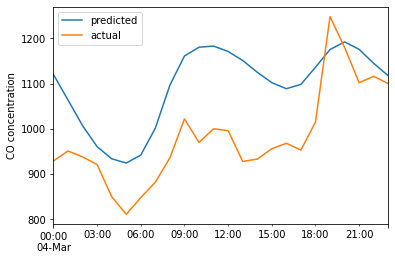

In [34]:
tmp.plot()
plt.ylabel("CO concentration")

Nice!

We now obtained the first 24 hours forecast. In the next video, we will add code to obtain the 24 hours forecast for various points in the test set.